In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [11]:
#change this to proper csv file
df = pd.read_csv('cleaned_songs_data.csv')

In [12]:
#using standard stopwords

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aliay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [14]:
# Remove rows with missing values
df = df.dropna()


allowed_genres = ['country', 'hip_hop', 'rock', 'jazz', 'pop']

# Use .isin() to filter rows where 'genre' is in the allowed list
df = df[df['genre'].isin(allowed_genres)]


In [15]:
#training and splitting data

X_train, X_test, y_train, y_test = train_test_split(df['lyrics'], df['genre'], test_size=0.2)


text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=list(stop_words))),
    ('clf', svm.SVC()),
])

text_clf.fit(X_train, y_train)

y_pred = text_clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     country       0.98      0.88      0.93        51
     hip_hop       0.94      0.84      0.89        37
        jazz       0.88      0.71      0.79        21
         pop       0.70      0.90      0.79        39
        rock       0.78      0.83      0.81        30

    accuracy                           0.85       178
   macro avg       0.86      0.83      0.84       178
weighted avg       0.86      0.85      0.85       178



In [16]:
from textblob import TextBlob

# Adding sentiment column for genre sentiment analysis
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

df['sentiment'] = df['lyrics'].apply(get_sentiment)

df.head().sort_values(by='sentiment')





,artist_name,track_name,genre,lyrics,sentiment
4,Van Halen,Jump,rock,"Ow! I get up, and nothing gets me down You got...",-0.351231
2,David Bowie,Heroes,rock,"I, I will be king And you, you will be queen T...",-0.312500
1,Led Zeppelin,Immigrant Song,rock,"​ (Two, three, four) Ahh! Ahh! We come from th...",0.076623
3,Matchbox Twenty,Push,rock,"She said, ""I don't know if I've ever been good...",0.133681
0,Red Hot Chili Peppers,Can't Stop,rock,"Can't stop, addicted to the shindig Chop Top, ...",0.285294


In [17]:
# Display mean sentiment by genre
print(df.groupby('genre')['sentiment'].mean())


genre
country    0.092908
hip_hop   -0.002366
jazz       0.118467
pop        0.119794
rock       0.054094
Name: sentiment, dtype: float64


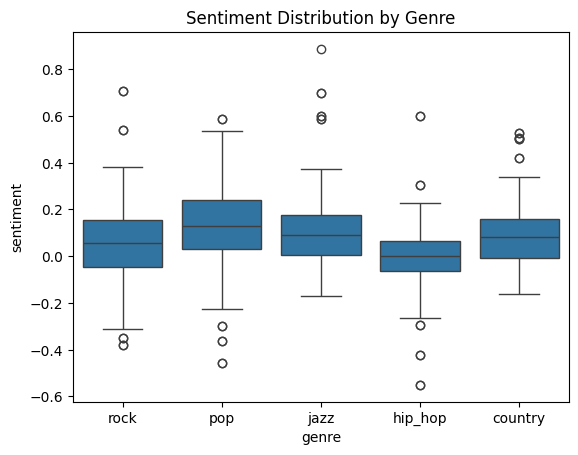

In [18]:
# Plot sentiment distribution by genre
sns.boxplot(x='genre', y='sentiment', data=df)
plt.title("Sentiment Distribution by Genre")
plt.show()